In [19]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(237)  # for reproducibility

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:30<00:00, 5.62MB/s] 


In [4]:
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10
Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

In [8]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

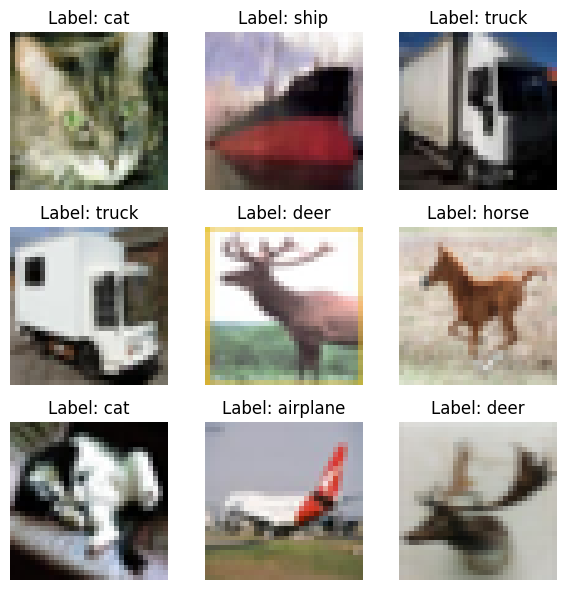

In [9]:
show_multiple_images(trainloader)

In [ ]:
def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [ ]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [14]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [15]:
vgg_16 = VGG()
print(vgg_16)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

vgg_13 = build_vgg13()
print(vgg_13)

VGG(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [18]:
BATCH_SIZE = 256
EPOCH = 15

# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []

for epoch in range(EPOCH):
    vgg_16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\tkdwl/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:53<00:00, 10.4MB/s] 


[1,   100] loss: 2.910
Epoch 1: Train Accuracy: 39.82%
Epoch 1: Validation Accuracy: 66.00%
[2,   100] loss: 0.923
Epoch 2: Train Accuracy: 70.79%
Epoch 2: Validation Accuracy: 75.61%
[3,   100] loss: 0.655
Epoch 3: Train Accuracy: 78.53%
Epoch 3: Validation Accuracy: 77.39%
[4,   100] loss: 0.543
Epoch 4: Train Accuracy: 82.13%
Epoch 4: Validation Accuracy: 80.48%
[5,   100] loss: 0.448
Epoch 5: Train Accuracy: 84.56%
Epoch 5: Validation Accuracy: 82.01%
[6,   100] loss: 0.396
Epoch 6: Train Accuracy: 86.87%
Epoch 6: Validation Accuracy: 82.86%
[7,   100] loss: 0.344
Epoch 7: Train Accuracy: 88.41%
Epoch 7: Validation Accuracy: 84.10%
[8,   100] loss: 0.296
Epoch 8: Train Accuracy: 89.81%
Epoch 8: Validation Accuracy: 84.40%
[9,   100] loss: 0.265
Epoch 9: Train Accuracy: 91.15%
Epoch 9: Validation Accuracy: 84.40%
[10,   100] loss: 0.231
Epoch 10: Train Accuracy: 92.20%
Epoch 10: Validation Accuracy: 84.75%
[11,   100] loss: 0.188
Epoch 11: Train Accuracy: 93.85%
Epoch 11: Validation

In [21]:
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\tkdwl/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:48<00:00, 11.8MB/s] 


[1,   100] loss: 2.786
Epoch 1: Train Accuracy: 43.04%
Epoch 1: Validation Accuracy: 69.61%
[2,   100] loss: 0.786
Epoch 2: Train Accuracy: 74.62%
Epoch 2: Validation Accuracy: 79.35%
[3,   100] loss: 0.587
Epoch 3: Train Accuracy: 80.72%
Epoch 3: Validation Accuracy: 81.24%
[4,   100] loss: 0.484
Epoch 4: Train Accuracy: 84.05%
Epoch 4: Validation Accuracy: 83.38%
[5,   100] loss: 0.402
Epoch 5: Train Accuracy: 86.36%
Epoch 5: Validation Accuracy: 84.20%
[6,   100] loss: 0.356
Epoch 6: Train Accuracy: 88.05%
Epoch 6: Validation Accuracy: 84.77%
[7,   100] loss: 0.306
Epoch 7: Train Accuracy: 89.64%
Epoch 7: Validation Accuracy: 85.98%
[8,   100] loss: 0.261
Epoch 8: Train Accuracy: 91.23%
Epoch 8: Validation Accuracy: 85.32%
[9,   100] loss: 0.220
Epoch 9: Train Accuracy: 92.27%
Epoch 9: Validation Accuracy: 85.85%
[10,   100] loss: 0.191
Epoch 10: Train Accuracy: 93.52%
Epoch 10: Validation Accuracy: 86.39%
[11,   100] loss: 0.156
Epoch 11: Train Accuracy: 94.63%
Epoch 11: Validation

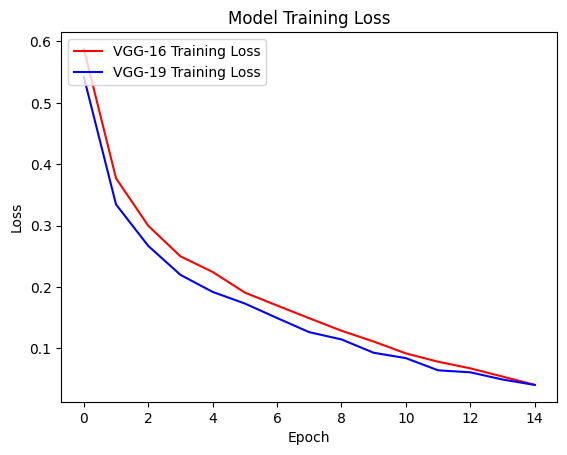

In [22]:
import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

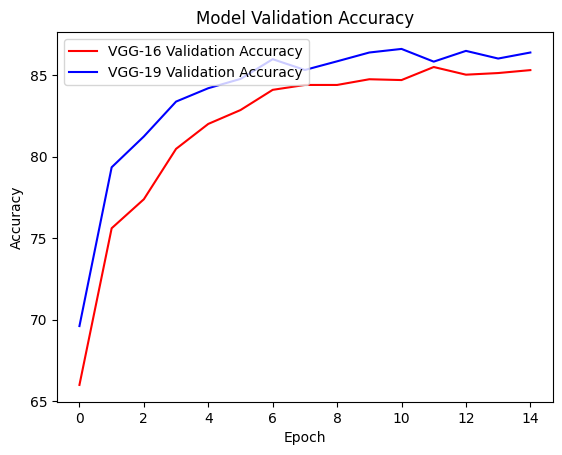

In [23]:
plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()